<a href="https://colab.research.google.com/github/opi-lab/stsiva-workshop/blob/main/notebooks/stsiva_workshop_notebook01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pinhole camera model fundamentals

*STSIVA Workshop - 2021*

**Speakers:**    
Jhacson Meza - [@jhacsonmeza](https://github.com/jhacsonmeza)    
Andrés G. Marrugo, PhD -     [@agmarrugo](https://github.com/agmarrugo)     
Universidad Tecnológica de Bolívar    

In this example, we will be exploring how to estimate the camera matrix and project world points from a known object. Adapted from [EGNN 512](http://inside.mines.edu/~whoff/) by W. Woff.

*The source of this notebook is located at https://github.com/opi-lab/stsiva-workshop/*

*Useful intro about [Colab](https://colab.research.google.com/notebooks/welcome.ipynb)*

*Useful intro about [OpenCV](https://opencv.org/)*

### The image of a cube

A cube has vertices in world coordinates: (0,0,0), (1,0,0),
(1,1,0), (0,1,0), (0,0,1), (1,0,1), (1,1,1), (0,1,1). A camera is located at
(X,Y,Z) = (3,-4,2) in world coordinates. The camera points directly
at the origin and there is no roll about the axis (i.e., the +Z axis of the world points up in the image). 

Generate an image of a wireframe model of the cube as if were seen by the camera, as shown in the figure. Assume a pinhole camera model, with focal length = 600 pixels, where the image size is 640 pixels wide by 480 pixels high.

![](https://github.com/opi-lab/stsiva-workshop/raw/main/figures/cube.gif)

## Solution

We use the fact that the +Z axis of the camera is the direction in which it points. We can get this by computing the vector from the camera’s location, to the point at which it is looking (the world
origin): $\hat{\mathbf{z}} = -\mathbf{t}/|\mathbf{t}|$, where $\mathbf{t}$ is the location of the camera in the world.

Next, we know that there is no roll about the axis (i.e., the +Z axis of the world points up in the image). This is equivalent to saying that the +X axis of the camera lies in the XY plane of the world. We can get this by doing a cross product of the camera’s Z axis with world Z axis.

Finally, the Y axis of the camera is given by the cross product of the Z axis with the X axis.

## The code:

In [24]:
# Let's import the necessary libraries
import numpy as np
import cv2 
import matplotlib.pylab as plt
# from google.colab.patches import cv2_imshow # for image display
# import pandas as pd
# from skimage import io
# from PIL import Image 
# import urllib.request

In [25]:
# Create camera pose
tc_w = np.array([3, -4, 2]) # location of camera origin in world

# The z axis of camera is the unit vector from camera to the world origin
uz_w = -tc_w/np.linalg.norm(tc_w)

print('The camera z-axis:', uz_w)
 
# The x axis of camera is in xy plane of world.
ux_w = np.cross(uz_w, np.array([0, 0, 1]))
ux_w = ux_w/np.linalg.norm(ux_w)

print('The camera x-axis:', ux_w)

# finally, form the y axis
uy_w = np.cross(uz_w, ux_w);

print('The camera y-axis:', uy_w)

R_c_w = np.hstack((ux_w.reshape(3,1), uy_w.reshape(3,1), uz_w.reshape(3,1)))

print('The camera rotation matrix: \n', R_c_w)
H_c_w = np.hstack((R_c_w, tc_w.reshape(3,1)))
H_c_w = np.vstack((H_c_w, np.array([0, 0, 0, 1])))
H_w_c = np.linalg.inv(H_c_w)

The camera z-axis: [-0.55708601  0.74278135 -0.37139068]
The camera x-axis: [ 0.8  0.6 -0. ]
The camera y-axis: [ 0.22283441 -0.29711254 -0.92847669]
The camera rotation matrix: 
 [[ 0.8         0.22283441 -0.55708601]
 [ 0.6        -0.29711254  0.74278135]
 [-0.         -0.92847669 -0.37139068]]


In [26]:
# Create camera projection matrices
# Here are the given parameters of the camera:
H = 480 # height of image in pixels
W = 640 # width of image in pixels
f = 600 # focal length in pixels
cx = W/2 # optical center
cy = H/2

# % Intrinsic camera parameter matrix
K = np.array([[f, 0, cx], [0, f, cy], [0, 0, 1]])

print('The camera intrinsic matrix:\n', K)

# Extrinsic camera parameter matrix
Mext = H_w_c[0:3,:]
print('The camera extrinsic matrix:\n', Mext)

The camera intrinsic matrix:
 [[600.   0. 320.]
 [  0. 600. 240.]
 [  0.   0.   1.]]
The camera extrinsic matrix:
 [[ 8.00000000e-01  6.00000000e-01  1.86940324e-17 -2.92128642e-16]
 [ 2.22834406e-01 -2.97112541e-01 -9.28476691e-01  1.44658472e-16]
 [-5.57086015e-01  7.42781353e-01 -3.71390676e-01  5.38516481e+00]]


In [27]:
# Define model in world coords
# The complete set of vertices is
P_w = np.array([[0, 1, 1, 0, 0, 1, 1, 0],
                [0, 0, 1, 1, 0, 0, 1, 1],
                [0, 0, 0, 0, 1, 1, 1, 1],
                [1, 1, 1, 1, 1, 1, 1, 1]])
# print(P_w)

# P_w = P_w 

# Define the lines to be drawn (indices of starting and ending points)
# lower 4 points form a square
# upper 4 points form a square
# connect lower square to upper square
Lines = np.array([
    [0,  1],      
    [1,  2],
    [2,  3],
    [3,  0],
    [4,  5],      
    [5,  6],
    [6,  7],
    [7,  4],
    [0,  4],      
    [1,  5],
    [2,  6],
    [3, 7]])

In [28]:
# Do perspective projection
p_img = K @ Mext @ P_w

# We convert p_img from homogenous to cartesian
p_img = p_img[:-1]/p_img[-1]

print('The projected points are:')
print(p_img)

The projected points are:
[[320.         419.41842721 470.7846146  378.74725244 320.
  427.70329614 481.55494421 382.53739776]
 [240.         267.69230769 232.         210.90909091 128.88888889
  145.         124.28571429 112.25806452]]


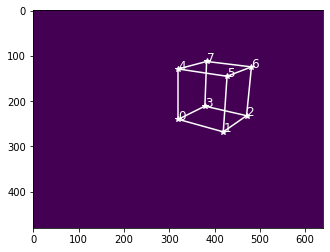

In [29]:
# Create image
I = np.zeros((H, W));

plt.imshow(I);

for i in range(0, p_img.shape[-1]):
  plt.plot(p_img[0,i], p_img[1,i], 'w*')
  plt.text(p_img[0,i], p_img[1,i], '{}'.format(i), fontsize=12, color='w')

for i in range(0, Lines.shape[0]):
  i1 = Lines[i, 0] # index of starting point
  i2 = Lines[i, 1] # index of ending point
  plt.plot([p_img[0, i1], p_img[0, i2]], [p_img[1, i1], p_img[1, i2]], color='w')

  
plt.show()

## TODO

Modify the above code to move the camera's location closer to or further away from the cube. You can also scale or shift the cube's coordinates and check that the image also moves.